In [1]:
from torchmetrics import Dice

/home/user0/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
from pathlib import Path

import numpy as np
from pytorch_lightning import LightningDataModule, Trainer, LightningModule


from tqdm import tqdm
from dataset.patch_dataset import BrainPatchesDataModule
from models.unet_module import UNet3
from dataset.roi_extraction import slice_image, reconstruct_patches
from utils import z_score_norm
import SimpleITK as sitk
import torch
from models.EM import ExpectationMaximization
import cv2
import matplotlib.pyplot as plt
cfg = {'pl_trainer':{'max_epochs': 20,
                     'devices': [0],
                     'accelerator': 'gpu'},
       
       'dataset':{'window_size': 64,
                  'stride': 32,
                  'img_threshold': 0.5,
                  'normalization': 'z_score'},
       
       'train_num_workers':8,
       'train_batch_size': 64,
       'val_num_workers':8,
       'val_batch_size': 64}

device = torch.device('cuda:2')
class BrainSegmenter:
    def __init__(self, model_checkpoint_path: Path,
                 cfg: dict):
        super().__init__()
        self.cfg = cfg
        self.model = UNet3.load_from_checkpoint(model_checkpoint_path).to(device)

        # disable randomness, dropout, etc...
        self.model.eval()


    def segment(self, image: np.ndarray,
                mask):
        
        segm_reconstructed = np.zeros_like(image)
        
        for slice in tqdm(range(image.shape[0])):
            # if slice <90:
            #     continue
            
            image_slices = slice_image(image[slice, :, :],
                                       self.cfg['dataset']['window_size'],
                                       self.cfg['dataset']['stride'])
            
            mask_slices = slice_image(mask[slice, :, :],
                                      self.cfg['dataset']['window_size'],
                                      self.cfg['dataset']['stride'])
            
            empty_slices_mask = np.asarray([s.sum()==0 for s in image_slices])
                        
            # CHANGE IF CHANGE NORMALIZATION OR ADD ANOTHER CHANNEL
            image_slices = [z_score_norm(slice, non_zero_region=True) for slice in image_slices]
            image_slices = np.expand_dims(np.asarray(image_slices, dtype=np.float32), axis=1)
            image_slices = torch.tensor(image_slices, requires_grad=False).to(device)
            
            # predict with the model
            y_hat = self.model(image_slices).detach().cpu().numpy()
            y_hat = np.argmax(y_hat, axis=1)
            
            segm_reconstructed[slice, :, :] = reconstruct_patches(y_hat,
                              image[slice, :, :],
                              cfg['dataset']['window_size'],
                              cfg['dataset']['stride'])
            
        # print(y_hat.shape, image_slices.shape, segm_reconstructed.shape)
        return segm_reconstructed

chk = '/home/user0/misa_vlex/brain_segmentation/outputs/lightning_logs/version_3/checkpoints/epoch=13-valid_dsc=0.9522.ckpt'
brsm = BrainSegmenter(chk, cfg)
img = sitk.ReadImage('/home/user0/misa_vlex/brain_segmentation/data/Validation_Set/IBSR_11/IBSR_11.nii.gz')
segm = sitk.ReadImage('/home/user0/misa_vlex/brain_segmentation/data/Validation_Set/IBSR_11/IBSR_11_seg.nii.gz')

em = ExpectationMaximization(3)
segm_pred = brsm.segment(sitk.GetArrayFromImage(img),
                         sitk.GetArrayFromImage(segm))


  0%|          | 0/256 [00:00<?, ?it/s]/home/user0/misa_vlex/brain_segmentation/utils.py:7: RuntimeWarning: Mean of empty slice.
  mean = img[img != 0].mean()
/home/user0/.local/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/user0/.local/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/user0/.local/lib/python3.10/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/user0/.local/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 29%|██▉       | 74/256 [00:11<00:19,  9.51it/s]/home/user0/misa_vlex/brain_segmentation/utils.py:15: RuntimeWarning: divide by z

In [25]:
img_np = sitk.GetArrayFromImage(img)
segm_np = sitk.GetArrayFromImage(segm)

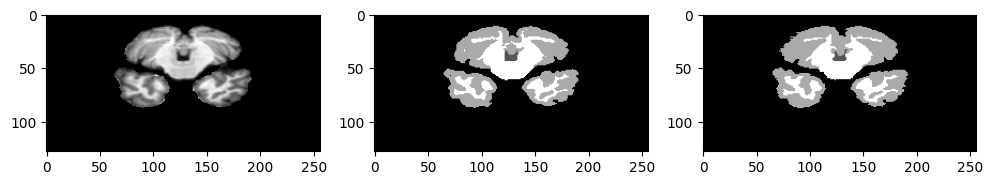

In [26]:
s = 100
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
# plt.title(f'DSC: {d(torch.Tensor(img[s, :, :]).unsqueeze(0), torch.tensor(mask_slices[s, :, :]).unsqueeze(0).int())}')
ax[0].imshow(img_np[s, :, :], cmap='gray')
ax[1].imshow(segm_pred[s, :, :], cmap='gray')
ax[2].imshow(segm_np[s, :, :], cmap='gray')

In [29]:
em = ExpectationMaximization(3)

print(em.compute_dice(segm_pred, segm_np))

{'CSF': 0.8901405784067781, 'WM': 0.9209871939551543, 'GM': 0.937117647460544}


In [28]:
rec_sitk = sitk.GetImageFromArray(segm_pred)
rec_sitk.CopyInformation(img)
sitk.WriteImage(rec_sitk, 'IBSR_11_val_segm_unet.nii.gz')

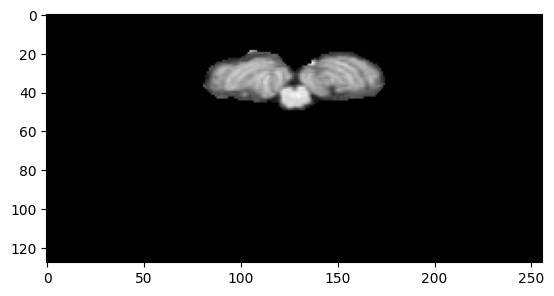

In [22]:
slice = 80
image_slices = slice_image(img_np[slice, :, :],
                           cfg['dataset']['window_size'],
                           cfg['dataset']['stride'])

plt.imshow(img_np[slice, :, :], cmap='gray')

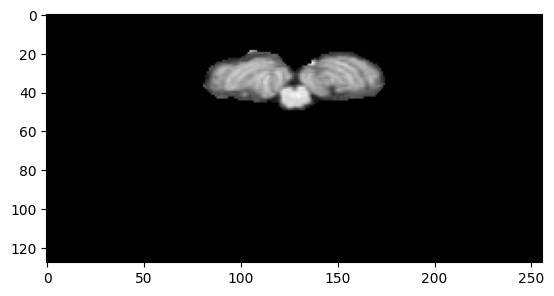

In [23]:
rec_img = reconstruct_patches(image_slices,
                              img_np[slice, :, :],
                              cfg['dataset']['window_size'],
                              cfg['dataset']['stride'])

plt.imshow(rec_img, cmap='gray')

In [20]:
slices, pred_slices, mask_slices = segm_pred

In [21]:
pred_slices.shape

(21, 4, 64, 64)

In [22]:
slices.shape

torch.Size([21, 1, 64, 64])

In [23]:
mask_slices.shape

(21, 64, 64)

In [24]:
# pred_slices = pred_slices.cpu().numpy()
slices = slices.cpu().numpy()

In [25]:
d = Dice(average='micro', num_classes=4, ignore_index=0)

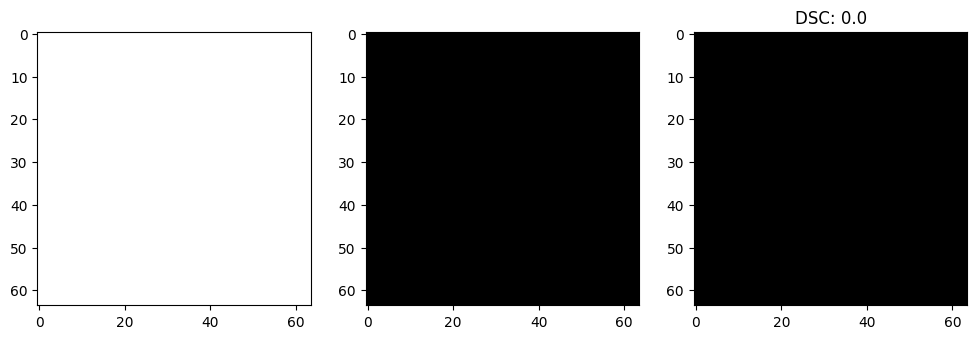

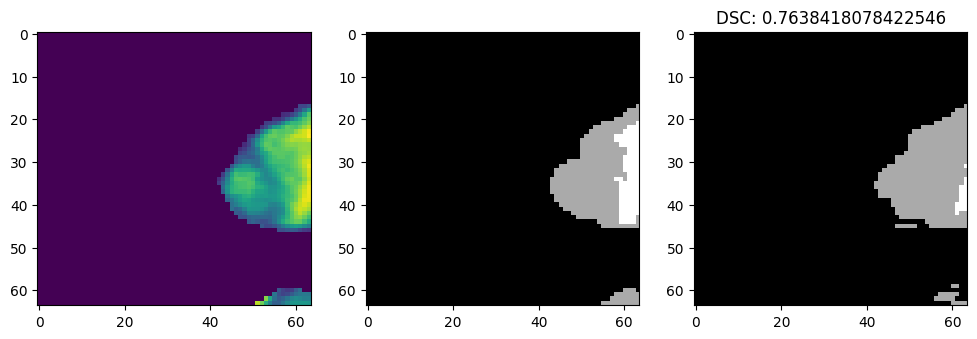

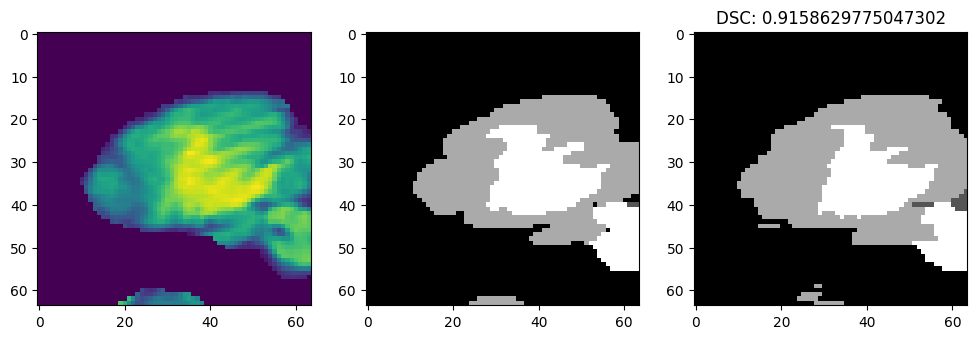

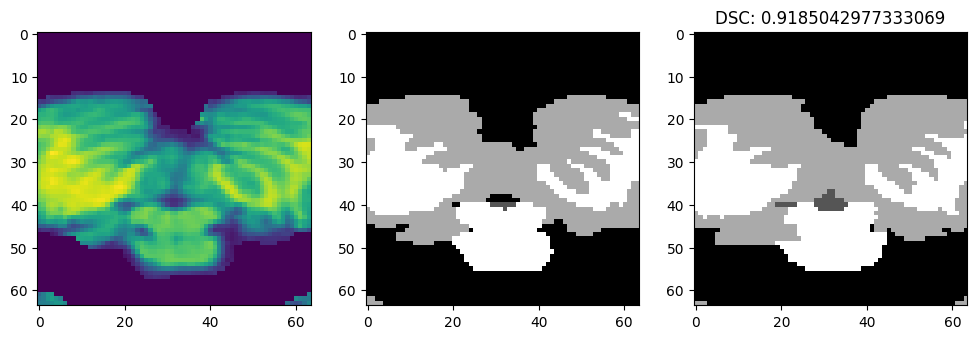

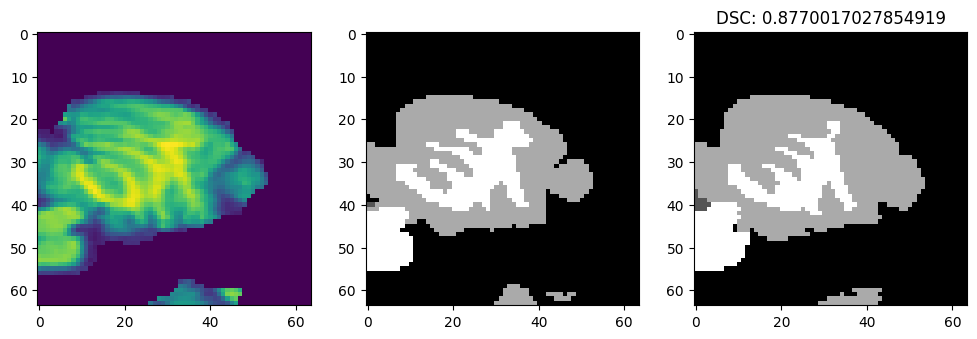

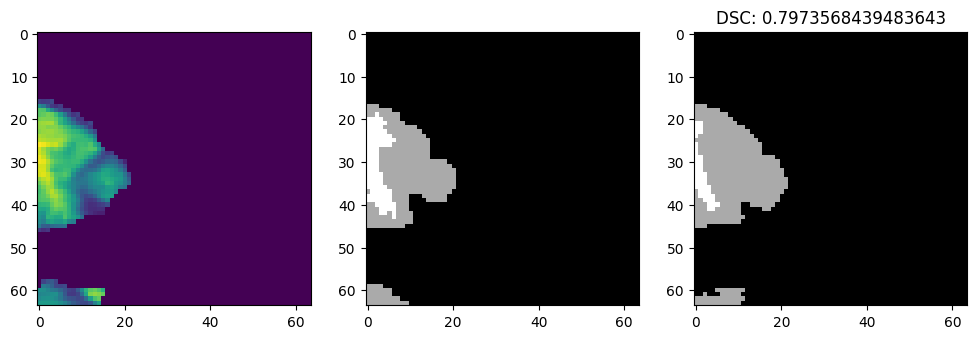

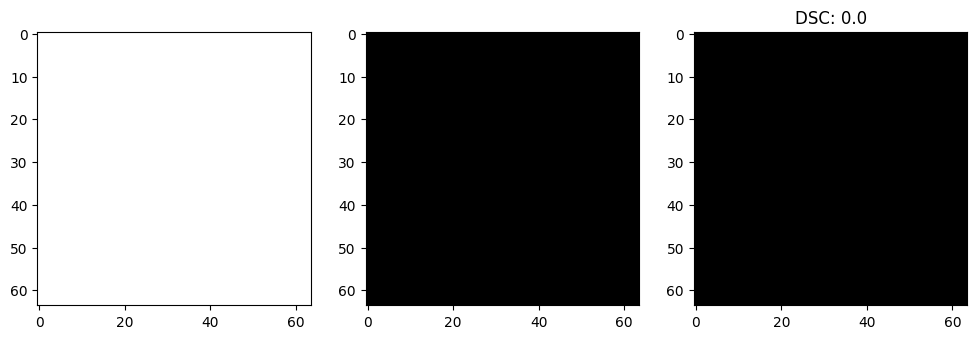

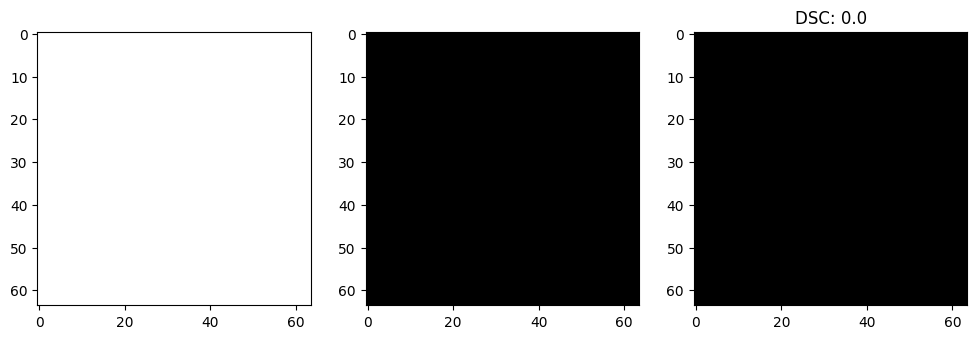

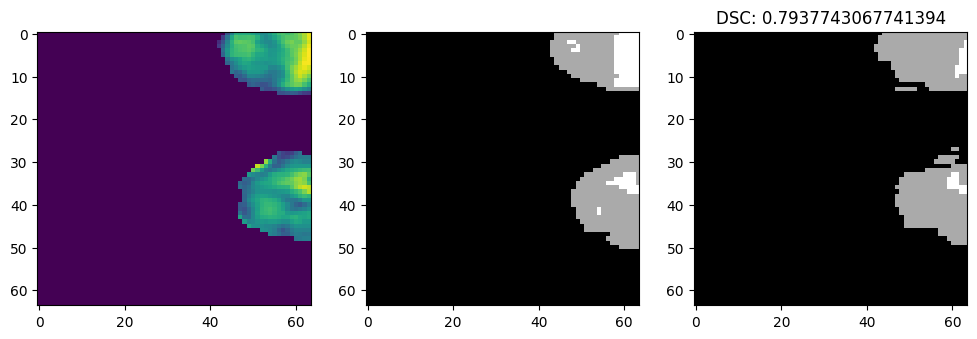

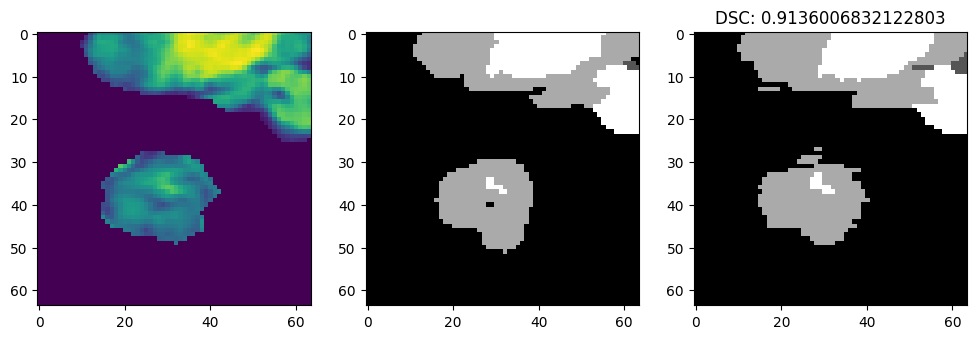

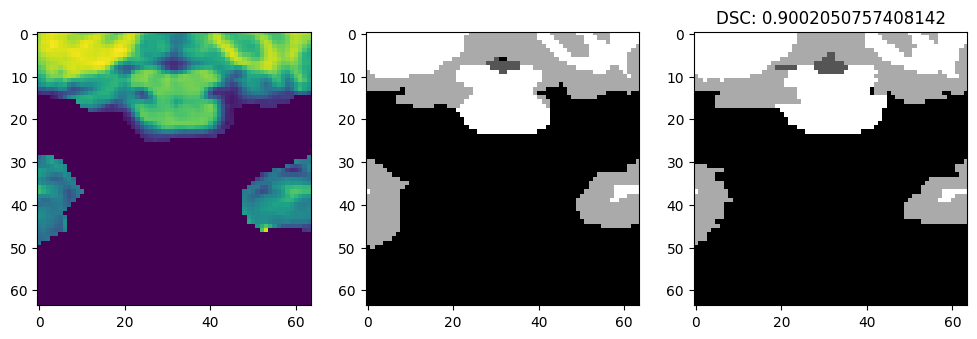

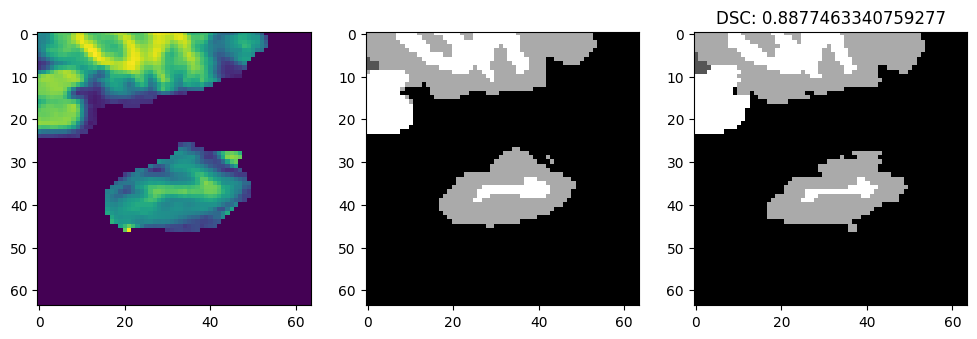

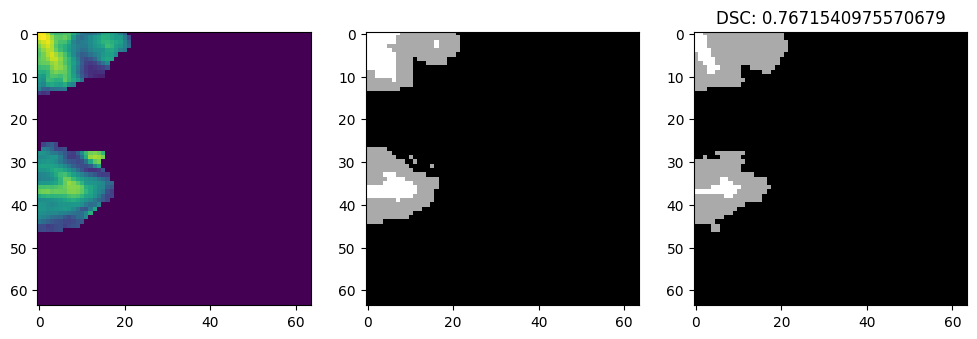

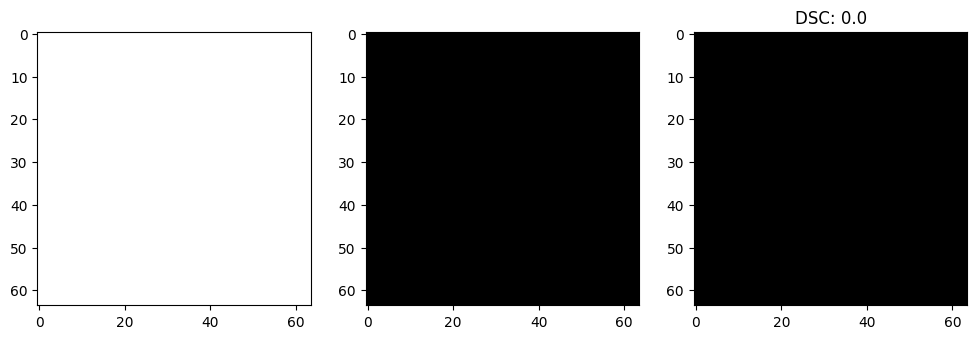

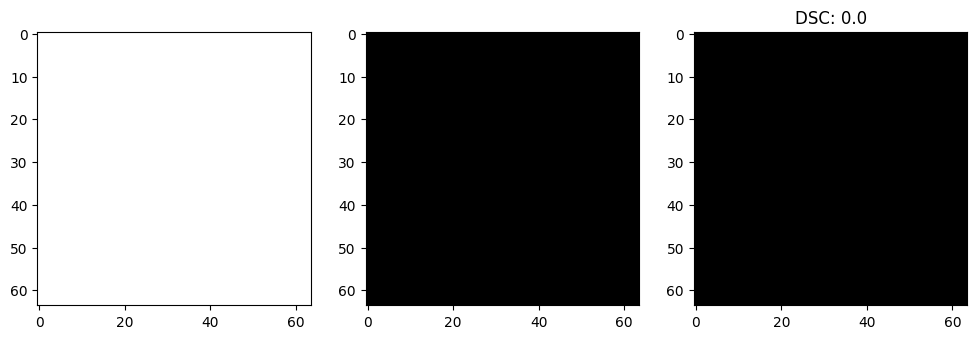

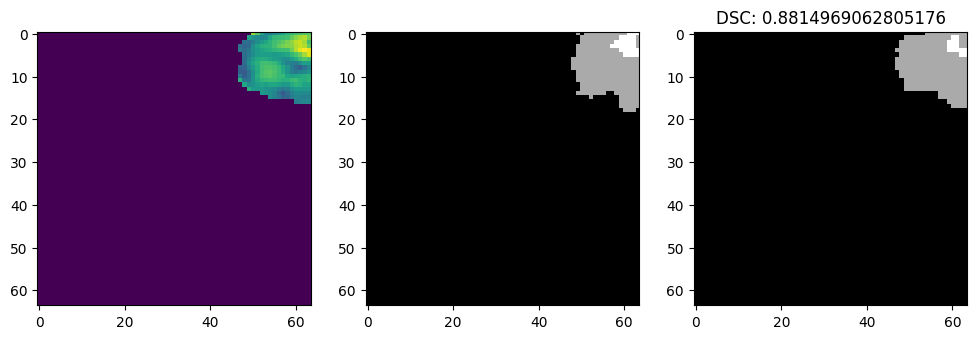

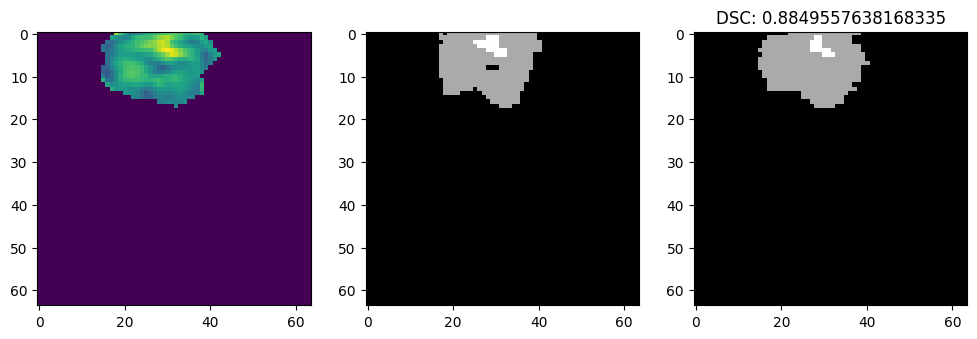

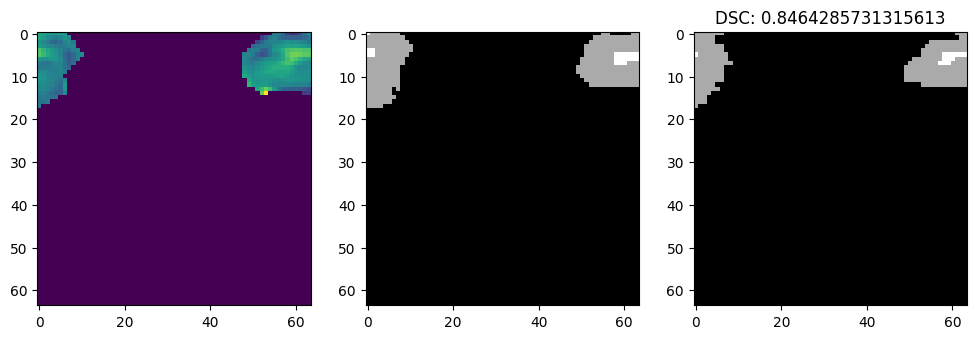

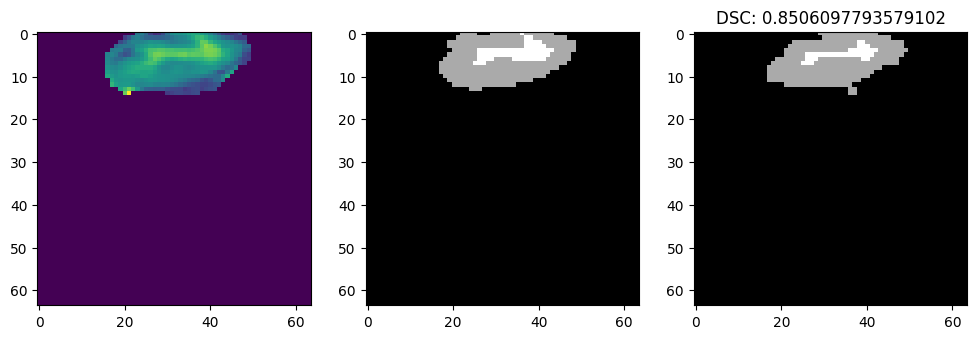

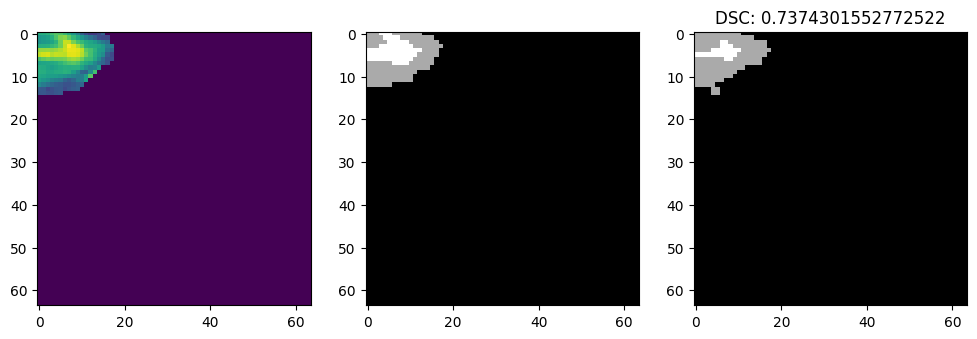

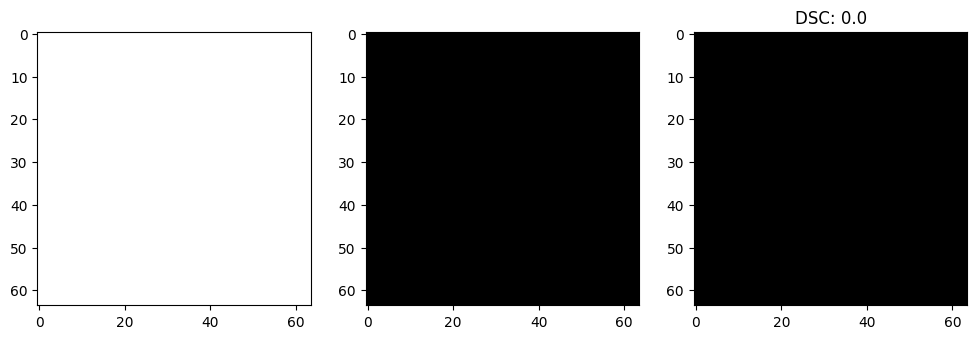

In [26]:
for s in range(len(pred_slices)):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    plt.title(f'DSC: {d(torch.Tensor(pred_slices[s, :, :]).unsqueeze(0), torch.tensor(mask_slices[s, :, :]).unsqueeze(0).int())}')
    ax[0].imshow(slices[s, 0, :, :])
    ax[1].imshow(np.argmax(pred_slices[s, :, :], axis=0), cmap='gray')
    ax[2].imshow(mask_slices[s, :, :], cmap='gray')
    plt.show()

In [ ]:
print(em.compute_dice(sitk.GetArrayFromImage(segm), segm_pred))
plt.imshow(segm_pred[:, 80, :])
plt.show()
plt.imshow(sitk.GetArrayFromImage(segm)[:, 80, :])
plt.show()
    

{'CSF': 0.0, 'WM': 0.0, 'GM': 0.0}


TypeError: tuple indices must be integers or slices, not tuple

In [ ]:
img_np = sitk.GetArrayFromImage(img)

In [ ]:
model = UNet3.load_from_checkpoint(chk).to(device)

In [ ]:
res = model(torch.Tensor(img_np[90:91, :, :]).unsqueeze(0).to(device))

In [ ]:
res.shape

torch.Size([1, 4, 128, 256])

In [ ]:
res_agg = torch.argmax(res, dim=1).cpu().numpy()

In [ ]:
d = Dice(average='micro', num_classes=4)

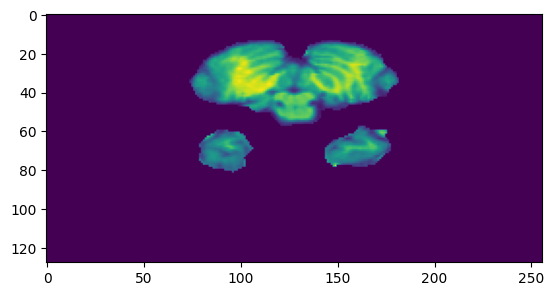

In [ ]:
plt.imshow(img_np[90:91, :, :][0])

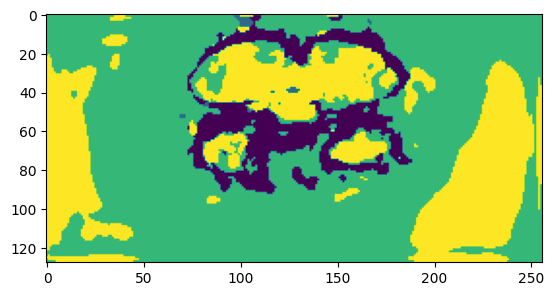

In [ ]:
plt.imshow(res_agg[0, :, :])

In [4]:
data_module = BrainPatchesDataModule(cfg, mode='train')
# data_module = data_module.data
data_module.prepare_data()

In [6]:
for x in data_module.train_dataloader():
    print(x)
    break

{'img': tensor([[[[-4.9486, -4.9486, -4.9486,  ..., -4.9486, -4.9486, -4.9486],
          [-4.9486, -4.9486, -4.9486,  ..., -4.9486, -4.9486, -4.9486],
          [-4.9486, -4.9486, -4.9486,  ..., -4.9486, -4.9486, -4.9486],
          ...,
          [ 0.3808,  0.3013,  0.0626,  ...,  0.1422, -0.2555, -0.5737],
          [-0.0169, -0.0169, -0.2555,  ...,  0.2217, -0.0965, -0.2555],
          [-0.3351, -0.4942, -0.5737,  ..., -0.0965, -0.4146, -0.5737]]],


        [[[-3.7634, -3.7634, -3.7634,  ...,  0.5079,  0.1388, -0.1776],
          [-3.7634, -3.7634, -3.7634,  ...,  0.4024, -0.0194, -0.2831],
          [-3.7634, -3.7634, -3.7634,  ...,  0.2442, -0.0722, -0.3885],
          ...,
          [-3.7634, -3.7634, -3.7634,  ...,  0.9825,  1.0880,  1.3516],
          [-3.7634, -3.7634, -3.7634,  ...,  1.2462,  1.2989,  1.4571],
          [-3.7634, -3.7634, -3.7634,  ...,  1.4044,  1.4571,  1.5626]]],


        [[[-4.5470, -4.5470, -4.5470,  ..., -4.5470, -4.5470, -4.5470],
          [-4.5470

In [7]:
model = UNet3.load_from_checkpoint(chk).to(device)

In [9]:
image_slices = x['img']
mask_slices = x['mask']

In [11]:
pred_slices = model(image_slices.to(device)).detach().cpu().numpy()

/tmp/ipykernel_2935207/1874798016.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.title(f'DSC: {d(torch.Tensor(pred_slices[s, :, :]).unsqueeze(0), torch.tensor(mask_slices[s, :, :]).unsqueeze(0).int())}')


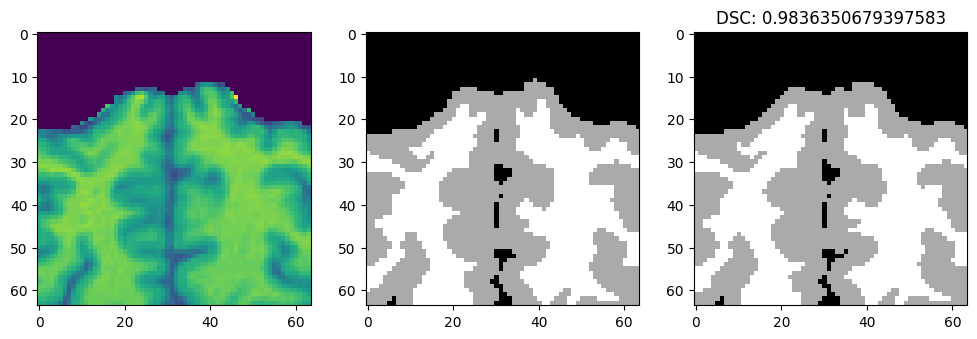

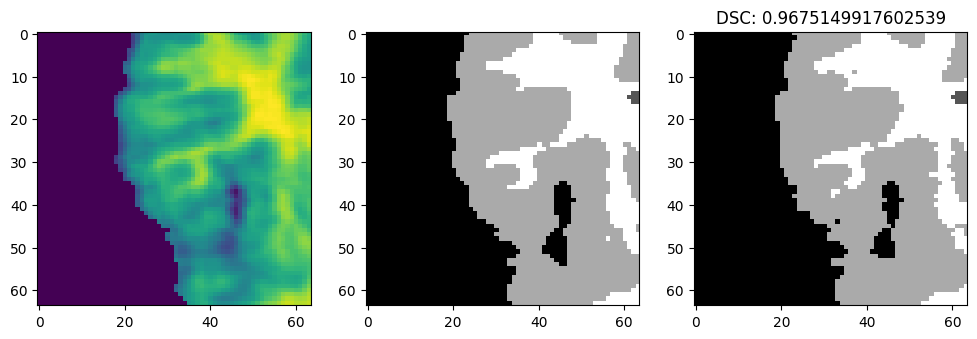

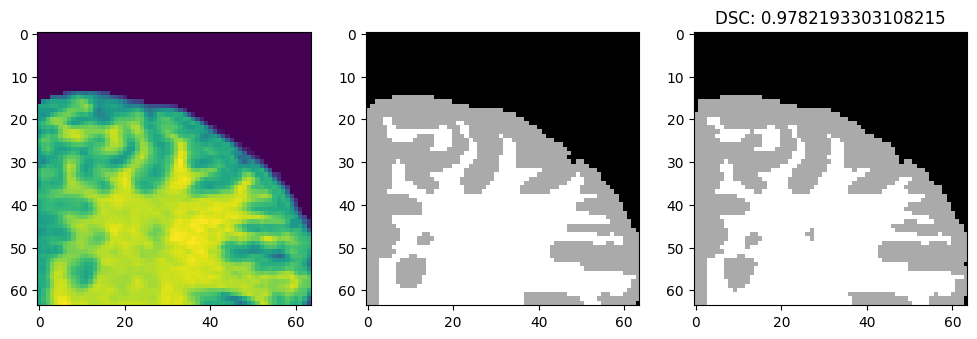

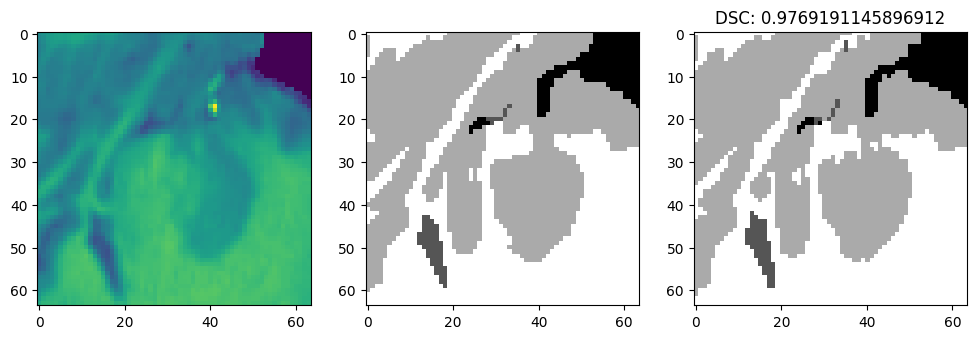

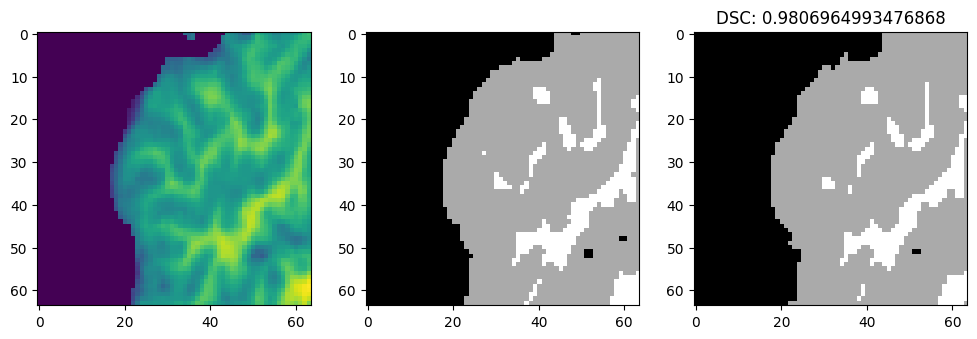

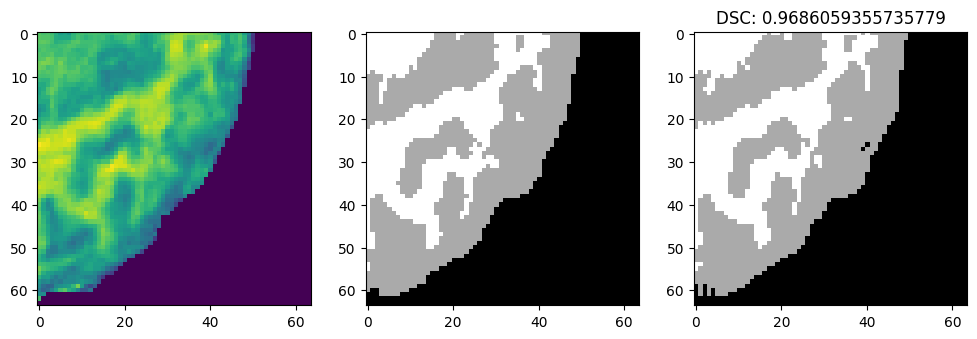

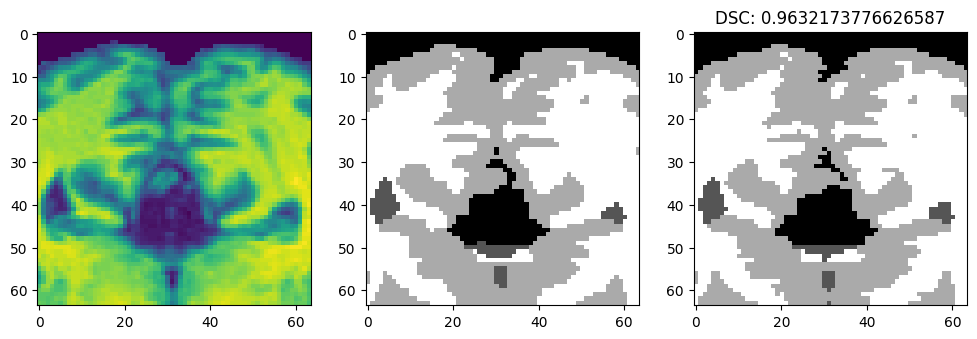

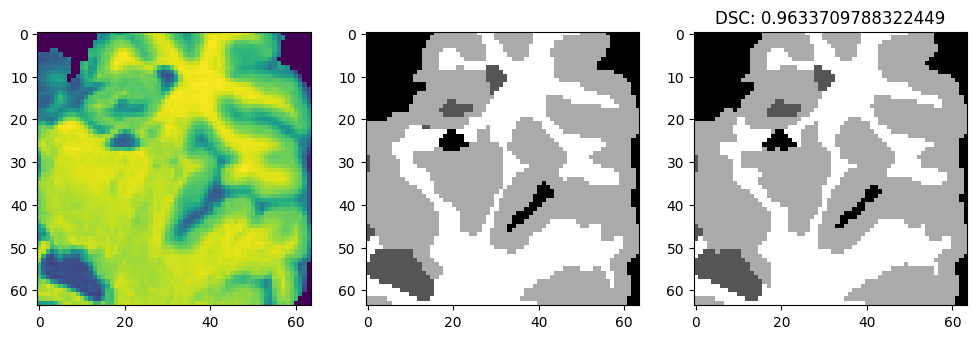

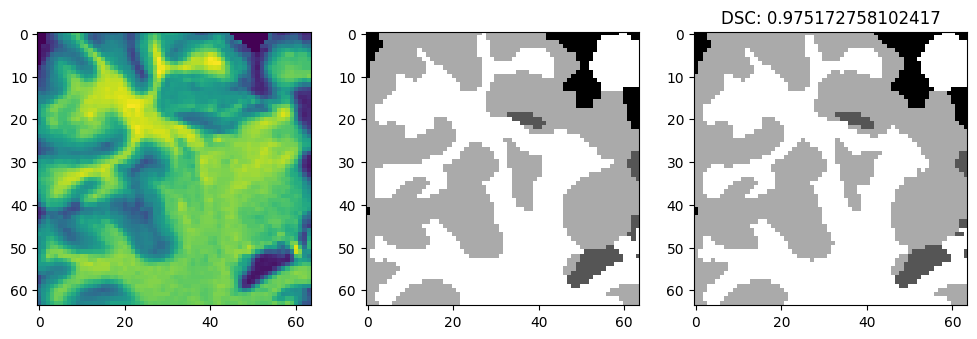

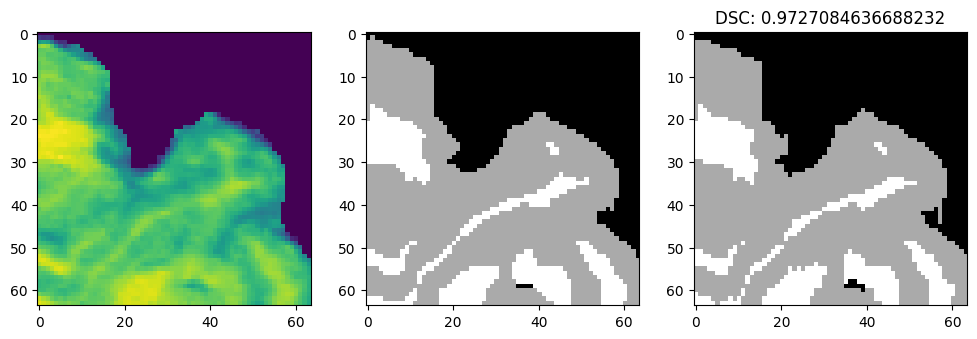

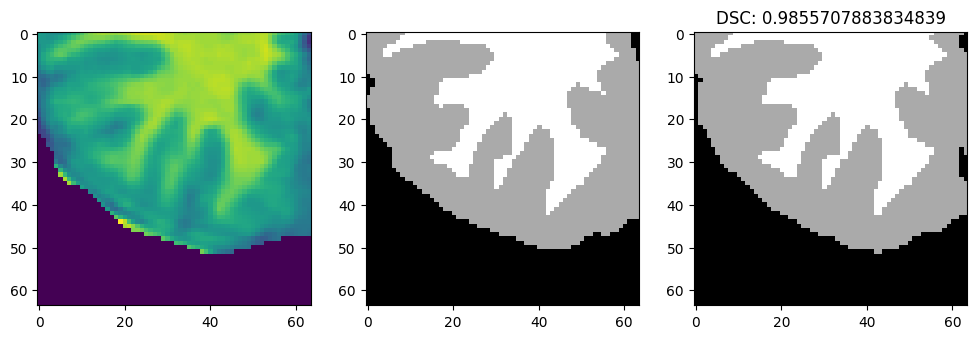

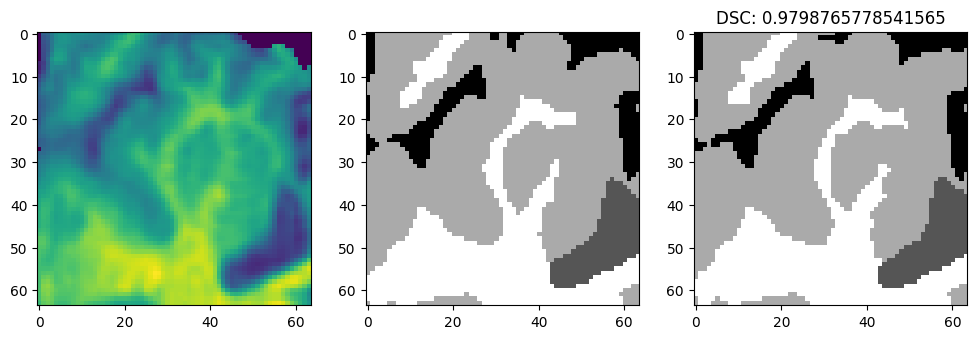

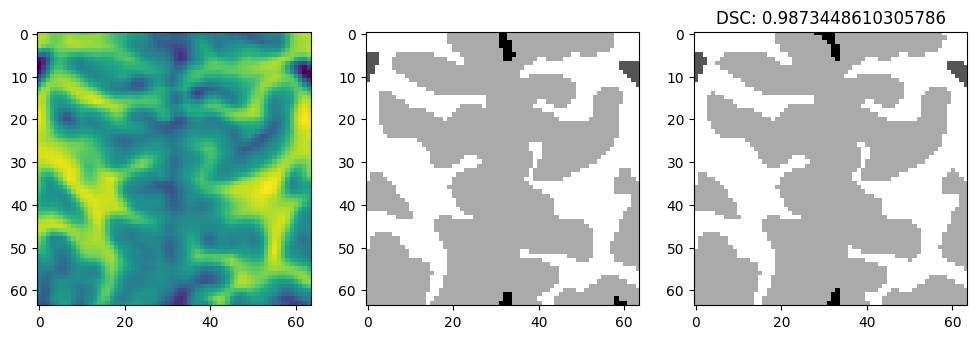

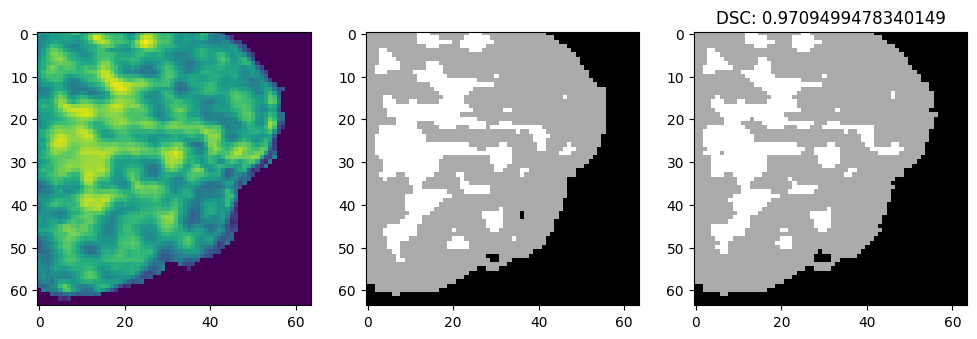

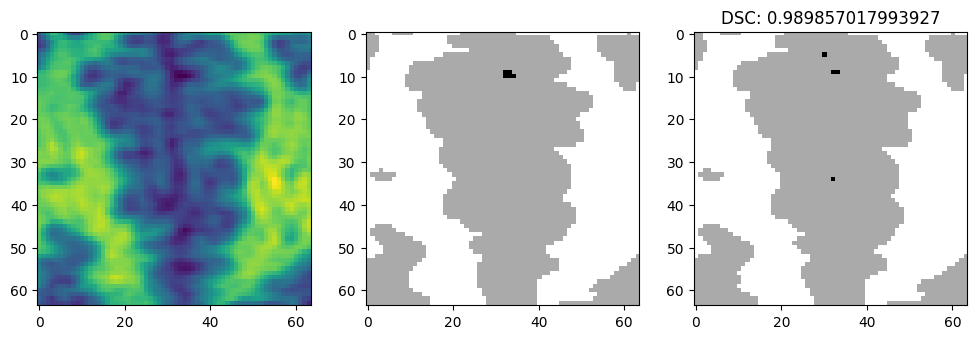

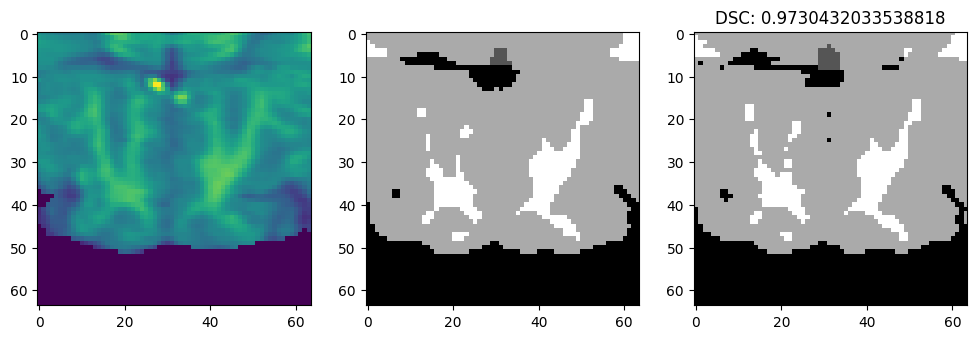

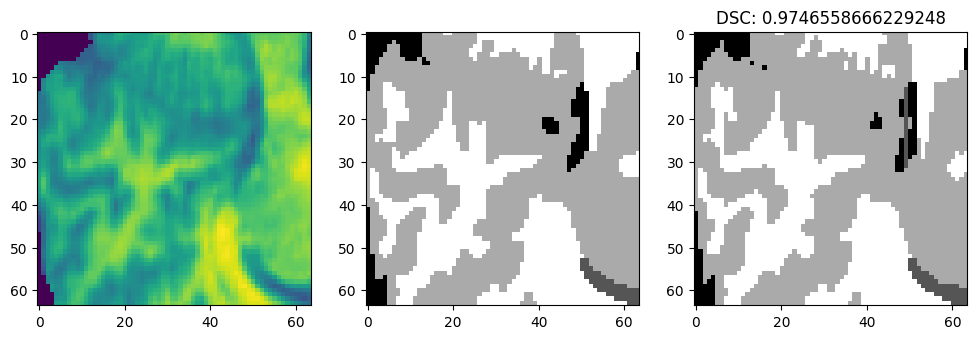

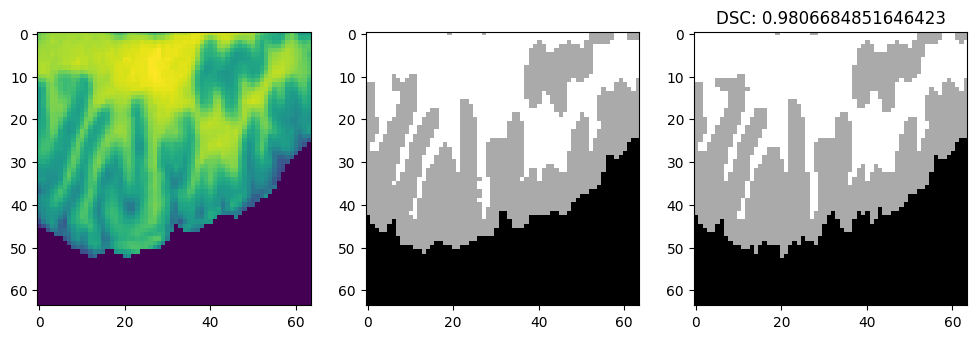

KeyboardInterrupt: 

In [16]:
for s in range(len(pred_slices)):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    plt.title(f'DSC: {d(torch.Tensor(pred_slices[s, :, :]).unsqueeze(0), torch.tensor(mask_slices[s, :, :]).unsqueeze(0).int())}')
    ax[0].imshow(image_slices[s, 0, :, :])
    ax[1].imshow(np.argmax(pred_slices[s, :, :], axis=0), cmap='gray')
    ax[2].imshow(mask_slices[s, :, :], cmap='gray')
    plt.show()